In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
import functools
import math
import numpy as np
import os
import time
import pandas as pd
from PIL import Image

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
train = pd.read_csv("/content/gdrive/My Drive/DashGC/Original/jester-v1-train.csv", sep = ';', names = ("video_id", "label", "frames", "label_id", "shape", "format"))
val = pd.read_csv("/content/gdrive/My Drive/DashGC/Original/jester-v1-validation.csv", sep = ';', names = ("video_id", "label", "frames", "label_id", "shape", "format"))
test = pd.read_csv("/content/gdrive/My Drive/DashGC/Original/jester-v1-test.csv", names = ("id", "label", "frames", "label_id", "shape", "format"))

In [0]:
# Decompress the compressed "Jester" dataset in Google Colab VM

start = time.time()
!cat /content/gdrive/My\ Drive/DashGC/Original/20bn-jester-v1-* | tar -xz
stop = time.time()
print('Decompression took', round(((stop - start) / 60), 2), 'mins')

Decompression took 18.41 mins


In [0]:
train["frames"] = train["video_id"].map(lambda a: len(os.listdir("/content/20bn-jester-v1/" + str(a))))
val["frames"] = val["video_id"].map(lambda a: len(os.listdir("/content/20bn-jester-v1/" + str(a))))
test["frames"] = test["id"].map(lambda a: len(os.listdir("/content/20bn-jester-v1/" + str(a))))

In [0]:
def imsize(filename):
    filepath = "/content/20bn-jester-v1/" + filename
    
    with Image.open(filepath) as img:
        width, height = img.size
    
    return (height, width)

In [0]:
train["shape"] = train["video_id"].map(lambda d: imsize(str(d) + "/" + str(os.listdir("/content/20bn-jester-v1/" + str(d))[0])))
val["shape"] = val["video_id"].map(lambda d: imsize(str(d) + "/" + str(os.listdir("/content/20bn-jester-v1/" + str(d))[0])))
test["shape"] = test["id"].map(lambda d: imsize(str(d) + "/" + str(os.listdir("/content/20bn-jester-v1/" + str(d))[0])))

In [0]:
def imformat(filename):
    filepath = "/content/20bn-jester-v1/" + filename
    
    with Image.open(filepath) as img:
        format = img.format
    
    return format

In [0]:
train["format"] = train["video_id"].map(lambda d: imformat(str(d) + "/" + str(os.listdir("/content/20bn-jester-v1/" + str(d))[0])))
val["format"] = val["video_id"].map(lambda d: imformat(str(d) + "/" + str(os.listdir("/content/20bn-jester-v1/" + str(d))[0])))
test["format"] = test["id"].map(lambda d: imformat(str(d) + "/" + str(os.listdir("/content/20bn-jester-v1/" + str(d))[0])))

In [0]:
label_to_index = {'Doing other things': 0, 'Drumming Fingers': 1, 'No gesture': 2, 'Pulling Hand In': 3, 'Pulling Two Fingers In': 4, 'Pushing Hand Away': 5, 'Pushing Two Fingers Away': 6, 'Rolling Hand Backward': 7, 'Rolling Hand Forward': 8, 'Shaking Hand': 9, 'Sliding Two Fingers Down': 10, 'Sliding Two Fingers Left': 11, 'Sliding Two Fingers Right': 12, 'Sliding Two Fingers Up': 13, 'Stop Sign': 14, 'Swiping Down': 15, 'Swiping Left': 16, 'Swiping Right': 17, 'Swiping Up': 18, 'Thumb Down': 19, 'Thumb Up': 20, 'Turning Hand Clockwise': 21, 'Turning Hand Counterclockwise': 22, 'Zooming In With Full Hand': 23, 'Zooming In With Two Fingers': 24, 'Zooming Out With Full Hand': 25, 'Zooming Out With Two Fingers': 26}

In [0]:
train["label_id"] = train["label"].map(lambda a: label_to_index[a])
val["label_id"] = val["label"].map(lambda a: label_to_index[a])

In [0]:
train.sort_values("video_id").head()

,video_id,label,frames,label_id,shape,format
97184,1,Doing other things,37,0,"(100, 176)",JPEG
111045,3,Pushing Two Fingers Away,37,6,"(100, 176)",JPEG
59351,4,Swiping Right,30,17,"(100, 176)",JPEG
36296,5,Rolling Hand Backward,35,7,"(100, 176)",JPEG
82397,6,Drumming Fingers,37,1,"(100, 176)",JPEG


In [0]:
val.sort_values("video_id").head()

,video_id,label,frames,label_id,shape,format
13384,16,Thumb Down,35,19,"(100, 176)",JPEG
4085,22,Zooming In With Full Hand,37,23,"(100, 176)",JPEG
9273,23,Sliding Two Fingers Right,38,12,"(100, 176)",JPEG
14519,30,Swiping Down,37,15,"(100, 176)",JPEG
3502,35,Drumming Fingers,36,1,"(100, 176)",JPEG


In [0]:
test.sort_values("id").head()

,id,label,frames,label_id,shape,format
9742,2,NaN,37,NaN,"(100, 176)",JPEG
117,15,NaN,33,NaN,"(100, 176)",JPEG
12528,18,NaN,32,NaN,"(100, 176)",JPEG
13234,21,NaN,37,NaN,"(100, 176)",JPEG
12684,32,NaN,36,NaN,"(100, 176)",JPEG


In [0]:
train.describe()

,video_id,frames,label_id
count,118562.000000,118562.000000,118562.000000
mean,74014.563663,35.586023,12.283000
std,42788.066743,2.355016,8.073005
min,1.000000,12.000000,0.000000
25%,36858.250000,35.000000,5.000000
50%,74009.500000,36.000000,12.000000
75%,111111.500000,37.000000,19.000000
max,148092.000000,70.000000,26.000000


In [0]:
val.describe()

,video_id,frames,label_id
count,14787.000000,14787.000000,14787.000000
mean,74259.369987,36.016636,12.003517
std,42597.398716,1.859350,8.173950
min,16.000000,13.000000,0.000000
25%,37732.000000,36.000000,5.000000
50%,74275.000000,37.000000,12.000000
75%,111037.500000,37.000000,19.000000
max,148080.000000,67.000000,26.000000


In [0]:
test.describe()

,id,label,frames,label_id
count,14743.000000,0.0,14743.000000,0.0
mean,74089.824120,NaN,35.803636,NaN
std,42604.755169,NaN,2.250138,NaN
min,2.000000,NaN,13.000000,NaN
25%,37441.000000,NaN,35.000000,NaN
50%,74177.000000,NaN,37.000000,NaN
75%,110787.500000,NaN,37.000000,NaN
max,148087.000000,NaN,46.000000,NaN


In [0]:
train["shape"].unique()

array([(100, 176), (100, 132), (100, 100), (100, 142), (100, 106),
       (100, 122), (100, 172)], dtype=object)

In [0]:
train["format"].unique()

array(['JPEG'], dtype=object)

In [0]:
val["shape"].unique()

array([(100, 132), (100, 176), (100, 100), (100, 142), (100, 122)],
      dtype=object)

In [0]:
val["format"].unique()

array(['JPEG'], dtype=object)

In [0]:
test["shape"].unique()

array([(100, 176), (100, 132), (100, 100), (100, 160)], dtype=object)

In [0]:
test["format"].unique()

array(['JPEG'], dtype=object)

In [0]:
train.sort_values("video_id").to_csv("/content/gdrive/My Drive/DashGC/Reorganized/Train.csv", sep = ",", index = False, encoding = "utf-8")
val.sort_values("video_id").to_csv("/content/gdrive/My Drive/DashGC/Reorganized/Validation.csv", sep = ",", index = False, encoding = "utf-8")
test.sort_values("id").to_csv("/content/gdrive/My Drive/DashGC/Reorganized/Test.csv", sep = ",", index = False, encoding = "utf-8")

In [0]:
train.groupby(by = "label").size()

label
Doing other things               9592
Drumming Fingers                 4371
No gesture                       4278
Pulling Hand In                  4323
Pulling Two Fingers In           4267
Pushing Hand Away                4357
Pushing Two Fingers Away         4291
Rolling Hand Backward            4032
Rolling Hand Forward             4132
Shaking Hand                     4258
Sliding Two Fingers Down         4348
Sliding Two Fingers Left         4292
Sliding Two Fingers Right        4206
Sliding Two Fingers Up           4219
Stop Sign                        4337
Swiping Down                     4259
Swiping Left                     4162
Swiping Right                    4084
Swiping Up                       4220
Thumb Down                       4390
Thumb Up                         4373
Turning Hand Clockwise           3216
Turning Hand Counterclockwise    3398
Zooming In With Full Hand        4251
Zooming In With Two Fingers      4302
Zooming Out With Full Hand       4281
Zoomin

In [0]:
val.groupby(by = "label").size()

label
Doing other things               1468
Drumming Fingers                  535
No gesture                        533
Pulling Hand In                   526
Pulling Two Fingers In            519
Pushing Hand Away                 538
Pushing Two Fingers Away          531
Rolling Hand Backward             493
Rolling Hand Forward              521
Shaking Hand                      528
Sliding Two Fingers Down          531
Sliding Two Fingers Left          519
Sliding Two Fingers Right         516
Sliding Two Fingers Up            522
Stop Sign                         536
Swiping Down                      520
Swiping Left                      494
Swiping Right                     486
Swiping Up                        508
Thumb Down                        536
Thumb Up                          539
Turning Hand Clockwise            385
Turning Hand Counterclockwise     399
Zooming In With Full Hand         526
Zooming In With Two Fingers       522
Zooming Out With Full Hand        526
Zoomin

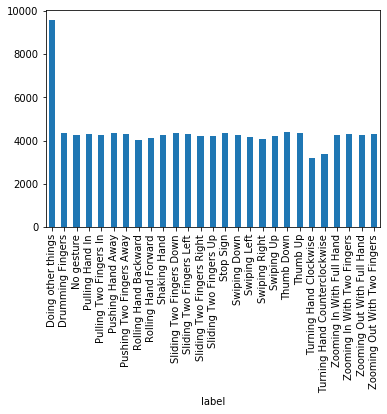

In [0]:
train.groupby(by = "label").size().plot.bar()

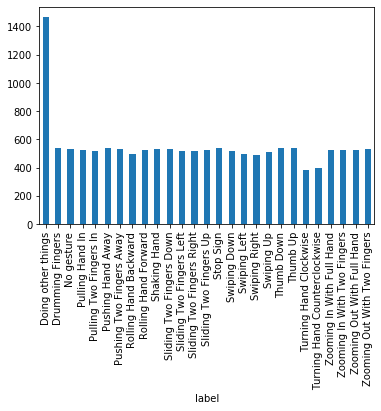

In [0]:
val.groupby(by = "label").size().plot.bar()

In [0]:
train.groupby(by = "frames").size()

frames
12        2
13        6
14        2
15        5
16        4
17        5
18        7
19       55
20       45
21       39
22      103
23      542
24      184
25      247
26      202
27      157
28      284
29      419
30      795
31     1704
32     5305
33     9702
34     9122
35     9375
36    22567
37    50420
38     6135
39      820
40      153
41       43
42       30
43       12
44       15
45       14
46       10
47        8
48        7
49        3
50        3
51        3
53        1
54        1
56        2
62        1
63        1
69        1
70        1
dtype: int64

In [0]:
val.groupby(by = "frames").size()

frames
13       1
14       1
20       2
21       2
22       2
23      13
24      22
25       1
26       8
27       3
28      14
29      23
30      74
31     120
32     491
33     822
34     827
35    1113
36    3143
37    7047
38     933
39      88
40      15
41       4
42       7
43       1
44       4
46       2
49       1
51       1
65       1
67       1
dtype: int64

In [0]:
test.groupby(by = "frames").size()

frames
13       2
14      10
15       4
16       7
17       3
18       2
19       1
21       5
22       7
23      28
24      41
25      16
26       6
27      14
28      54
29      33
30      79
31     176
32     489
33    1031
34     854
35    1040
36    3003
37    6981
38     740
39      86
40      14
42       4
43       3
44       4
45       2
46       4
dtype: int64

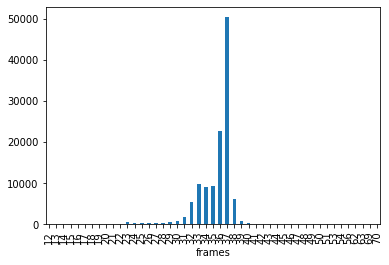

In [0]:
train.groupby(by = "frames").size().plot.bar()

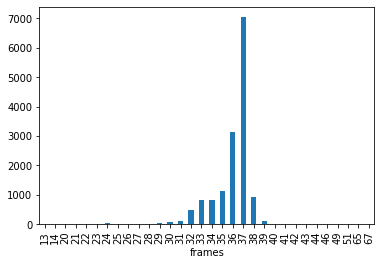

In [0]:
val.groupby(by = "frames").size().plot.bar()

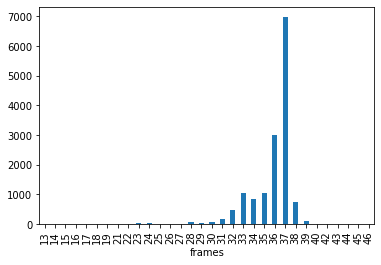

In [0]:
test.groupby(by = "frames").size().plot.bar()

In [0]:
train.groupby(by = "frames").size().describe()

count       47.000000
mean      2522.595745
std       8193.762351
min          1.000000
25%          3.500000
50%         30.000000
75%        351.500000
max      50420.000000
dtype: float64

In [0]:
val.groupby(by = "frames").size().describe()

count      32.000000
mean      462.093750
std      1349.372981
min         1.000000
25%         1.750000
50%         7.500000
75%        96.000000
max      7047.000000
dtype: float64

In [0]:
test.groupby(by = "frames").size().describe()

count      32.000000
mean      460.718750
std      1328.019098
min         1.000000
25%         4.000000
50%        14.000000
75%       108.500000
max      6981.000000
dtype: float64

In [0]:
val.sort_values("video_id").head()

,video_id,label,frames,label_id,shape,format
13384,16,Thumb Down,35,19,"(100, 176)",JPEG
4085,22,Zooming In With Full Hand,37,23,"(100, 176)",JPEG
9273,23,Sliding Two Fingers Right,38,12,"(100, 176)",JPEG
14519,30,Swiping Down,37,15,"(100, 176)",JPEG
3502,35,Drumming Fingers,36,1,"(100, 176)",JPEG


In [0]:
val.sort_values("video_id").head().to_numpy()

array([[16, 'Thumb Down', 35, 19, (100, 176), 'JPEG'],
       [22, 'Zooming In With Full Hand', 37, 23, (100, 176), 'JPEG'],
       [23, 'Sliding Two Fingers Right', 38, 12, (100, 176), 'JPEG'],
       [30, 'Swiping Down', 37, 15, (100, 176), 'JPEG'],
       [35, 'Drumming Fingers', 36, 1, (100, 176), 'JPEG']], dtype=object)

In [0]:
sample_val = val.groupby(by = "label")
sample_val.apply(lambda x: x.sample(frac=0.3))

video_id  ... format
label                                         ...       
Doing other things           810       50883  ...   JPEG
                             14390    138871  ...   JPEG
                             13176     43137  ...   JPEG
                             7144     118715  ...   JPEG
                             9849     122962  ...   JPEG
...                                      ...  ...    ...
Zooming Out With Two Fingers 9040     130382  ...   JPEG
                             2308      90978  ...   JPEG
                             5885     143744  ...   JPEG
                             5437     109911  ...   JPEG
                             1589      92514  ...   JPEG

[4437 rows x 6 columns]

In [0]:
sample_val.apply(lambda x: x.sample(frac=0.3)).head()

video_id               label  ...       shape  format
label                                                   ...                    
Doing other things 11769     98305  Doing other things  ...  (100, 132)    JPEG
                   5088      91332  Doing other things  ...  (100, 176)    JPEG
                   2437     111352  Doing other things  ...  (100, 176)    JPEG
                   977       61352  Doing other things  ...  (100, 176)    JPEG
                   12000     39744  Doing other things  ...  (100, 176)    JPEG

[5 rows x 6 columns]

In [0]:
sample_val.apply(lambda x: x.sample(frac=0.3)).describe()

,video_id,frames,label_id
count,4437.000000,4437.000000,4437.000000
mean,74356.949515,36.018706,12.010593
std,42675.799992,1.804179,8.175053
min,16.000000,13.000000,0.000000
25%,37623.000000,36.000000,5.000000
50%,74946.000000,37.000000,12.000000
75%,111477.000000,37.000000,19.000000
max,148033.000000,44.000000,26.000000


In [0]:
train.groupby(by = ["label", "frames"]).agg(lambda x:x.value_counts().index[0])

video_id  label_id       shape format
label                        frames                                       
Doing other things           12         34856         0  (100, 176)   JPEG
                             13         52616         0  (100, 132)   JPEG
                             19        102367         0  (100, 132)   JPEG
                             20         93174         0  (100, 132)   JPEG
                             21         73083         0  (100, 176)   JPEG
...                                       ...       ...         ...    ...
Zooming Out With Two Fingers 40        140581        26  (100, 176)   JPEG
                             42         58975        26  (100, 176)   JPEG
                             44        139638        26  (100, 132)   JPEG
                             48         76648        26  (100, 132)   JPEG
                             56         10944        26  (100, 176)   JPEG

[725 rows x 4 columns]

In [0]:
train.groupby(by = ["label", "frames"]).size().sort_values(ascending=False).head(30)

label                          frames
Doing other things             37        4374
Pulling Two Fingers In         37        1859
Zooming Out With Two Fingers   37        1847
No gesture                     37        1844
Pushing Two Fingers Away       37        1843
Thumb Up                       37        1841
Sliding Two Fingers Down       37        1832
Zooming Out With Full Hand     37        1832
Pulling Hand In                37        1829
Swiping Down                   37        1824
Stop Sign                      37        1821
Drumming Fingers               37        1818
Sliding Two Fingers Left       37        1816
Pushing Hand Away              37        1812
Thumb Down                     37        1810
Zooming In With Two Fingers    37        1801
Zooming In With Full Hand      37        1799
Shaking Hand                   37        1789
Rolling Hand Forward           37        1788
Sliding Two Fingers Right      37        1780
Sliding Two Fingers Up         37        1

In [0]:
val.groupby(by = ["label", "frames"]).size().sort_values(ascending=False).head(30)

label                          frames
Doing other things             37        713
                               36        274
Zooming In With Full Hand      37        262
Zooming Out With Two Fingers   37        261
Zooming Out With Full Hand     37        260
Stop Sign                      37        259
Drumming Fingers               37        257
Zooming In With Two Fingers    37        257
No gesture                     37        256
Pulling Hand In                37        250
Thumb Down                     37        250
Sliding Two Fingers Down       37        249
Swiping Down                   37        248
Swiping Left                   37        247
Pushing Hand Away              37        246
Sliding Two Fingers Left       37        246
Shaking Hand                   37        245
Rolling Hand Forward           37        244
Sliding Two Fingers Up         37        244
Sliding Two Fingers Right      37        242
Swiping Up                     37        241
Pushing Two Finge

In [0]:
train[train["frames"]==37].groupby(by = "label").size().sort_values(ascending=False)

label
Doing other things               4374
Pulling Two Fingers In           1859
Zooming Out With Two Fingers     1847
No gesture                       1844
Pushing Two Fingers Away         1843
Thumb Up                         1841
Sliding Two Fingers Down         1832
Zooming Out With Full Hand       1832
Pulling Hand In                  1829
Swiping Down                     1824
Stop Sign                        1821
Drumming Fingers                 1818
Sliding Two Fingers Left         1816
Pushing Hand Away                1812
Thumb Down                       1810
Zooming In With Two Fingers      1801
Zooming In With Full Hand        1799
Shaking Hand                     1789
Rolling Hand Forward             1788
Sliding Two Fingers Right        1780
Sliding Two Fingers Up           1779
Swiping Up                       1768
Swiping Left                     1762
Swiping Right                    1730
Rolling Hand Backward            1715
Turning Hand Counterclockwise    1380
Turnin

In [0]:
train[train["frames"]==37].groupby(by = "label").size().transform(lambda x: 1327/x).sort_values(ascending=True)

label
Doing other things               0.303384
Pulling Two Fingers In           0.713825
Zooming Out With Two Fingers     0.718462
No gesture                       0.719631
Pushing Two Fingers Away         0.720022
Thumb Up                         0.720804
Zooming Out With Full Hand       0.724345
Sliding Two Fingers Down         0.724345
Pulling Hand In                  0.725533
Swiping Down                     0.727522
Stop Sign                        0.728720
Drumming Fingers                 0.729923
Sliding Two Fingers Left         0.730727
Pushing Hand Away                0.732340
Thumb Down                       0.733149
Zooming In With Two Fingers      0.736813
Zooming In With Full Hand        0.737632
Shaking Hand                     0.741755
Rolling Hand Forward             0.742170
Sliding Two Fingers Right        0.745506
Sliding Two Fingers Up           0.745925
Swiping Up                       0.750566
Swiping Left                     0.753121
Swiping Right               

In [0]:
functools.reduce(math.gcd, train[train["frames"]==37].groupby(by = "label").size().to_numpy())

1

In [0]:
train[train["frames"]==37].groupby(by = "label").size().transform(lambda x: math.gcd(1327, x)).sort_values(ascending=True)

label
Doing other things                  1
Zooming In With Two Fingers         1
Zooming In With Full Hand           1
Turning Hand Counterclockwise       1
Thumb Up                            1
Thumb Down                          1
Swiping Up                          1
Swiping Right                       1
Swiping Left                        1
Swiping Down                        1
Stop Sign                           1
Zooming Out With Full Hand          1
Sliding Two Fingers Up              1
Sliding Two Fingers Left            1
Sliding Two Fingers Down            1
Shaking Hand                        1
Rolling Hand Forward                1
Rolling Hand Backward               1
Pushing Two Fingers Away            1
Pushing Hand Away                   1
Pulling Two Fingers In              1
Pulling Hand In                     1
No gesture                          1
Drumming Fingers                    1
Sliding Two Fingers Right           1
Zooming Out With Two Fingers        1
Turnin

In [0]:
train[train["frames"]==37].groupby(by = "label").apply(lambda x: x.sample(n = 1327))

video_id  ... format
label                                          ...       
Doing other things           79382     117269  ...   JPEG
                             16694      66329  ...   JPEG
                             33499      53081  ...   JPEG
                             22561      25261  ...   JPEG
                             118231     96467  ...   JPEG
...                                       ...  ...    ...
Zooming Out With Two Fingers 25109      35485  ...   JPEG
                             80116      58244  ...   JPEG
                             20900     125574  ...   JPEG
                             37777     146889  ...   JPEG
                             107816     31562  ...   JPEG

[35829 rows x 6 columns]

In [0]:
train_set = train[train["frames"]==37].groupby(by = "label").apply(lambda x: x.sample(n = 1327))[["video_id", "label_id"]].to_numpy()

In [0]:
val[val["frames"]==37].groupby(by = "label").size().sort_values(ascending=False)

label
Doing other things               713
Zooming In With Full Hand        262
Zooming Out With Two Fingers     261
Zooming Out With Full Hand       260
Stop Sign                        259
Zooming In With Two Fingers      257
Drumming Fingers                 257
No gesture                       256
Thumb Down                       250
Pulling Hand In                  250
Sliding Two Fingers Down         249
Swiping Down                     248
Swiping Left                     247
Pushing Hand Away                246
Sliding Two Fingers Left         246
Shaking Hand                     245
Rolling Hand Forward             244
Sliding Two Fingers Up           244
Sliding Two Fingers Right        242
Pushing Two Fingers Away         241
Swiping Up                       241
Rolling Hand Backward            239
Thumb Up                         238
Pulling Two Fingers In           233
Swiping Right                    231
Turning Hand Clockwise           196
Turning Hand Counterclockwise   

In [0]:
val[val["frames"]==37].groupby(by = "label").size().transform(lambda x: 192/x).sort_values(ascending=True)

label
Doing other things               0.269285
Zooming In With Full Hand        0.732824
Zooming Out With Two Fingers     0.735632
Zooming Out With Full Hand       0.738462
Stop Sign                        0.741313
Zooming In With Two Fingers      0.747082
Drumming Fingers                 0.747082
No gesture                       0.750000
Thumb Down                       0.768000
Pulling Hand In                  0.768000
Sliding Two Fingers Down         0.771084
Swiping Down                     0.774194
Swiping Left                     0.777328
Sliding Two Fingers Left         0.780488
Pushing Hand Away                0.780488
Shaking Hand                     0.783673
Sliding Two Fingers Up           0.786885
Rolling Hand Forward             0.786885
Sliding Two Fingers Right        0.793388
Pushing Two Fingers Away         0.796680
Swiping Up                       0.796680
Rolling Hand Backward            0.803347
Thumb Up                         0.806723
Pulling Two Fingers In      

In [0]:
functools.reduce(math.gcd, val[val["frames"]==37].groupby(by = "label").size().to_numpy())

1

In [0]:
val[val["frames"]==37].groupby(by = "label").size().transform(lambda x: math.gcd(192, x)).sort_values(ascending=True)

label
Doing other things                 1
Drumming Fingers                   1
Zooming In With Two Fingers        1
Pulling Two Fingers In             1
Pushing Two Fingers Away           1
Rolling Hand Backward              1
Shaking Hand                       1
Swiping Up                         1
Stop Sign                          1
Swiping Left                       1
Pulling Hand In                    2
Zooming In With Full Hand          2
Thumb Up                           2
Thumb Down                         2
Sliding Two Fingers Right          2
Swiping Right                      3
Zooming Out With Two Fingers       3
Sliding Two Fingers Down           3
Zooming Out With Full Hand         4
Rolling Hand Forward               4
Turning Hand Clockwise             4
Sliding Two Fingers Up             4
Sliding Two Fingers Left           6
Pushing Hand Away                  6
Swiping Down                       8
No gesture                        64
Turning Hand Counterclockwise   

In [0]:
val[val["frames"]==37].groupby(by = "label").apply(lambda x: x.sample(n = 192))

video_id  ... format
label                                         ...       
Doing other things           928      116035  ...   JPEG
                             4344      98222  ...   JPEG
                             10118     72909  ...   JPEG
                             13062     73024  ...   JPEG
                             122       76867  ...   JPEG
...                                      ...  ...    ...
Zooming Out With Two Fingers 6775      21905  ...   JPEG
                             12753     61979  ...   JPEG
                             9068     139458  ...   JPEG
                             8934     143295  ...   JPEG
                             7677      93718  ...   JPEG

[5184 rows x 6 columns]

In [0]:
val_set = val[val["frames"]==37].groupby(by = "label").apply(lambda x: x.sample(n = 192))[["video_id", "label_id"]].to_numpy()

In [0]:
test[test["frames"]==37].count()

id          6981
label          0
frames      6981
label_id       0
shape       6981
format      6981
dtype: int64

In [0]:
test_set = test[test["frames"]==37][["id", "label_id"]].to_numpy()

## Data Pipeline
This is the ETL (Extract, Transform & Load) Data input pipeline to be used for preprocessing

In [0]:
# Decode the video frames as int64 values of color & recast it as float32
# Resize the video frames into a squared size (100, 100, channels = 3)

def preprocess_image(image):
    '''
    Decodes the binary form to normalized vector (aka tensor) form
    '''
    # img_raw = tf.io.read_file(img_path)
    # img_tensor = tf.image.decode_image(img_raw)
    image = tf.image.decode_jpeg(image, channels=3) # imports RGB channels, jpeg doesn't have a 4th channel alpha for transparency like png
    image = tf.image.resize(image, [100, 100]) # original dimensions are (176, 100)
    # image = tf.image.convert_image_dtype(image, tf.float32)
    image /= 255.0  # normalize to [0,1] range
    return image

# Turning this into a tf.function as test_dataset uses it directly
@tf.function
def load_and_preprocess_image(path):
    '''
    Open the file from path as binary

    NOTE: AutoGraph supports common Python statements like `while`, `for`, `if`, `break`, `continue` and `return`, with support for nesting. 
    That means you can use `Tensor` expressions in the condition of `while` and `if` statements, or iterate over a `Tensor` in a `for` loop. 
    [ref](https://www.tensorflow.org/guide/function#use_python_control_flow)
    '''
    image = tf.io.read_file(path)
    return preprocess_image(image)

@tf.function
def load_and_preprocess_from_path_label(path, label):
    '''
    Returns image, label pair as a tuple
    
    NOTE: If your code uses multiple functions, you don't need to annotate them all - any functions called from an annotated function 
    will also run in graph mode. [ref](https://www.tensorflow.org/guide/function#the_tffunction_decorator)
    '''
    return (load_and_preprocess_image(path), label)

In [0]:
vids = ["0" * (5 - math.ceil(math.log10(x))) + str(x) + ".jpg" if x != 10**(math.ceil(math.log10(x))) else "0" * (4 - math.ceil(math.log10(x))) + str(x) + ".jpg" for x in range(1,38)]
vids[0] = "00001.jpg"
print(vids)

['00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg', '00006.jpg', '00007.jpg', '00008.jpg', '00009.jpg', '00010.jpg', '00011.jpg', '00012.jpg', '00013.jpg', '00014.jpg', '00015.jpg', '00016.jpg', '00017.jpg', '00018.jpg', '00019.jpg', '00020.jpg', '00021.jpg', '00022.jpg', '00023.jpg', '00024.jpg', '00025.jpg', '00026.jpg', '00027.jpg', '00028.jpg', '00029.jpg', '00030.jpg', '00031.jpg', '00032.jpg', '00033.jpg', '00034.jpg', '00035.jpg', '00036.jpg', '00037.jpg']


In [0]:
train["video_id"] = "/content/20bn-jester-v1" + train["video_id"].astype(str)
val["video_id"] = "/content/20bn-jester-v1" + val["video_id"].astype(str)
test["id"] = "/content/20bn-jester-v1" + test["id"].astype(str)

In [0]:
train_set = train[train["frames"]==37].groupby(by = "label").apply(lambda x: x.sample(n = 1327))[["video_id", "label_id"]].to_numpy()
val_set = val[val["frames"]==37].groupby(by = "label").apply(lambda x: x.sample(n = 192))[["video_id", "label_id"]].to_numpy()
test_set = test[test["frames"]==37][["id", "label_id"]].to_numpy()

In [0]:
val_set[:, 0]


array(['/content/20bn-jester-v1/content/20bn-jester-v1134744',
       '/content/20bn-jester-v1/content/20bn-jester-v17533',
       '/content/20bn-jester-v1/content/20bn-jester-v1134563', ...,
       '/content/20bn-jester-v1/content/20bn-jester-v1101020',
       '/content/20bn-jester-v1/content/20bn-jester-v125301',
       '/content/20bn-jester-v1/content/20bn-jester-v1124955'],
      dtype=object)

In [0]:
val_set[:, 1]

array([0, 0, 0, ..., 26, 26, 26], dtype=object)

In [0]:
val_set[:]

array([['/content/20bn-jester-v1/content/20bn-jester-v1134744', 0],
       ['/content/20bn-jester-v1/content/20bn-jester-v17533', 0],
       ['/content/20bn-jester-v1/content/20bn-jester-v1134563', 0],
       ...,
       ['/content/20bn-jester-v1/content/20bn-jester-v1101020', 26],
       ['/content/20bn-jester-v1/content/20bn-jester-v125301', 26],
       ['/content/20bn-jester-v1/content/20bn-jester-v1124955', 26]],
      dtype=object)